# Roche SEIRD Model Optimisation

In this notebook we present how to use the `epimodels` module to perform parameter optimisation for the  parameters specified by the Roche model, using time-dependent region-specific contact matrices.

The analysis is run for:
 - Dates: **15 Feb 2020** - **25 June 2020**;
 - PHE s of interest: **London**.

We use realistic serology and mortality data extracted from the REACT survey and GOV.UK data.

*The Roche model is built by F. Hoffmann-La Roche Ltd.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom, norm
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

# Set random seed
np.random.seed(28)

## Model Setup
### Define setup matrices for the Roche Model

In [2]:
# Populate the model
total_days =  132
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
## Initial state of the system
# for w in weeks:
#     weeks_matrices_region = []
#     for r in regions:
#         path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
#         region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#         regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#         weeks_matrices_region.append(regional)

#     matrices_region.append(weeks_matrices_region)

# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]

## Matrices contact
# time_changes_contact = [1]
# time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# Initial state of the system
weeks_matrices_region = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
    weeks_matrices_region.append(regional)

matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

# NPIs data
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
path = os.path.join('../../data/npi_data/')
general_npi = np.loadtxt(os.path.join(path, 'uk_flags.csv'), dtype=bool, delimiter=',').tolist()
time_changes_flag = np.loadtxt(os.path.join(path, 'times_flags.csv'), dtype=int, delimiter=',').tolist()

reg_levels_npi = [np.loadtxt(os.path.join(path, 'uk_npis.csv'), dtype=int, delimiter=',').tolist()]
time_changes_npi = np.loadtxt(os.path.join(path, 'times_npis.csv'), dtype=int, delimiter=',').tolist()

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)
model.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = []
susceptibles.append(total_susceptibles[-1])

# Initial number of infectives
ICs_multiplier = [10000, 5000]
infectives_pre = (ICs_multiplier[0] * np.ones((len(regions), len(age_groups)))).tolist()
infectives_pre_ss = (ICs_multiplier[1] * np.ones((len(regions), len(age_groups)))).tolist()

infectives = (np.array(infectives_pre) + np.array(infectives_pre_ss)).tolist()

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

In [4]:
# Set ICs parameters
ICs = em.RocheICs(
    model=model,
    susceptibles_IC=susceptibles,
    exposed_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_IC=infectives_pre,
    infectives_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_pre_ss_IC=infectives_pre_ss,
    infectives_asym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_sym_ss_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives_q_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    recovered_asym_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    dead_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set average times in compartments
compartment_times = em.RocheCompartmentTimes(
    model=model,
    k=4.5,
    kS=1,
    kQ=1,
    kR=9,
    kRI=10
)

# Set proportion of asymptomatic, super-spreader and dead cases
proportion_parameters = em.RocheProportions(
    model=model,
    Pa = 0.716,
    Pss = 0.106,
    Pd = 0.05
)

# Set transmission parameters
transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.228,
    beta_max=2.63,
    bss=3.11,
    gamma=0.5,
    s50=51.5
)

# Set other simulation parameters
simulation_parameters = em.RocheSimParameters(
    model=model,
    region_index=1,
    method='RK45',
    times=times
)

# Set all parameters in the controller
parameters = em.RocheParametersController(
    model=model,
    ICs=ICs,
    compartment_times=compartment_times,
    proportion_parameters=proportion_parameters,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

## Read Death and Serology data

In [5]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [6]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [7]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

## Optimisation Procedure

In [8]:
# Initialise optimisation for the model
roche_optimisation = em.inference.RocheSEIRInfer(model)

# Add model, death, tests and NPIs data to the inference structure
roche_optimisation.read_model_data(susceptibles, infectives)
roche_optimisation.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
roche_optimisation.read_serology_data(tests, positives_data, serology_times, sens, spec)
roche_optimisation.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

# Run optimisation structure
found, log_post_value = roche_optimisation.optimisation_problem_setup(times, wd=1, wp=0)

Maximising LogPDF
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 11
Iter. Eval.  Best      Current   Time m:s
0     11     -15031.93 -15031.93   0:01.3
1     22     -14642.13 -14642.13   0:02.8
2     33     -14242.44 -14242.44   0:04.1
3     44     -14127.43 -14127.43   0:05.5


/Users/ioaros/opt/anaconda3/lib/python3.8/site-packages/cma/evolution_strategy.py:3630: RuntimeWarning: invalid value encountered in double_scalars
  current_fitness_range = max(es.fit.fit) - min(es.fit.fit)


20    231    -10284.31 -10662.4    0:16.2
40    451    -3852.444 -3852.444   0:31.1
50    550    -3443.473 -3477.22    0:38.5
Halting: Maximum number of iterations (50) reached.
[0.44639836 0.09923582 0.07646937 0.2310788  0.1036966  0.18053678
 0.15311979 0.02760554 0.2210437  0.00580577 0.53915729 3.02027628] -3443.473039832965
Optimisation phase is finished.


### Run the model with optimised parameter choices to produce predicted timelines for the:
 - number of new infections
 - number of deaths
 - R number

In [9]:
n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
#predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    parameters.simulation_parameters.region_index = r + 1

    parameters.ICs.infectives_pre = ((1-found[0]) * np.array(infectives)).tolist()
    parameters.ICs.infectives_pre_ss = (found[0] * np.array(infectives)).tolist()

    # parameters.proportion_parameters.Pa = found[1:(1+model._num_ages)]
    # parameters.proportion_parameters.Pss = found[1+model._num_ages]
    parameters.proportion_parameters.Pd = found[-(3+model._num_ages):(-3)]

    parameters.transmission_parameters.beta_min = found[-3]
    parameters.transmission_parameters.beta_max = found[-2]
    parameters.transmission_parameters.bss = found[-1]
    
    #r_fix = np.empty(len(times))
    model_reg_deaths_data = np.empty(len(times))

    #m_fix = em.MultiTimesInfectivity(
    #    matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], dI, susceptibles)

    # Run model and number of new infections for all age groups
    print(parameters())
    model_output = model.simulate(parameters)

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
    #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec.append(np.array(model_reg_new_infections))
    predicted_deaths.append(model_reg_deaths_data)
    #predicted_reprod_num.append(r_fix)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
#predicted_reprod_num = np.array(predicted_reprod_num)

[1, 53565, 237359, 641486, 635602, 1304264, 1499291, 668999, 584130, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8304.02457970441, 8304.02457970441, 8304.02457970441, 8304.02457970441, 8304.02457970441, 8304.02457970441, 8304.02457970441, 8304.02457970441, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6695.97542029559, 6695.97542029559, 6695.97542029559, 6695.97542029559, 6695.97542029559, 6695.97542029559, 6695.97542029559, 6695.97542029559, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.5, 1, 1, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 0.716, 0.716, 0.716, 0.716, 0.716, 0.716, 0.716, 0.716, 0.106, 0.09923581861278524, 0.07646936765383604, 0.23107880328548996, 0.1036966010252775, 0.18053677896635728, 0.153119790866607

In [10]:
for t, time in enumerate(times):
    #    r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)], temp_variation=parameters[8][r][t])
        print(np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections)))
   

4.924482838246953
11.453512304015296
18.133291039537415
24.51685332874154
30.517398399815463
36.15064314544233
41.45134268042861
46.45177204872027
51.178815402633866
55.65509333538067
59.90040058647624
63.93272808097482
67.76862166370533
71.42352229036784
74.91176723321888
78.24668467183456
81.44060146565731
84.50485004710065
87.4496991898885
90.28456068022321
93.01818761961506
95.65801315133089
98.21053636531825
100.6823290728161
103.078856409272
105.40406056498193
107.66211325119141
109.69999268663119
111.62620426135052
113.46288028548474
113.50532572398461
113.22810998140633
112.83956547905898
112.4648037086328
111.91806557569848
111.16936297403227
110.22110121282476
109.0223917437515
107.69101096785172
106.26187983441919
104.75598540371853
103.18796783121057
101.56879504347995
99.90687606069537
98.20963163397205
96.48330276893213
94.73238775103519
92.96150976143709
91.17489780741744
89.37586196807143
87.5677229514601
85.7535251812024
83.93603345778794
82.11772757887017
80.300991892

## Plot data vs predicted

### Setup ``plotly`` and default settings for plotting

In [11]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

### Select predicted quantities to plot

In [12]:
# Set up traces to plot
new_infec_pred = []
deaths_pred = []
#reprod_num_pred = []

for r, _ in enumerate(model.regions):
    # Compute the prediction 
    new_infec_pred.append(predicted_new_infec[r,:])
    deaths_pred.append(predicted_deaths[r,:])
    #reprod_num_pred.append(predicted_reprod_num[r,:])

### Plot observed versus predicted using model with optimised parameters

In [13]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (continuous predicted timeline and pointwise observed numbers each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_pred[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    #fig.add_trace(
    #    go.Scatter(
    #        x=times,
    #        y=reprod_num_pred[r].tolist(),
    #        mode='lines',
    #        name=trace_name[r],
    #        showlegend=False,
    #        line_color=colours[r]
    #    ),
    #    row= 3,
    #    col= 1
    #)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-3-optimisation.pdf')
fig.show()

<ipython-input-13-e48c6bf424d7>:26: RuntimeWarning:

invalid value encountered in true_divide



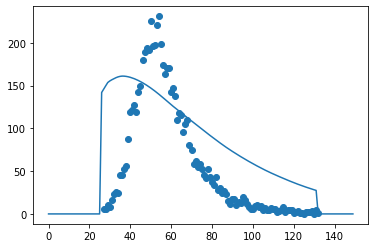

In [14]:
plt.plot(model.actual_deaths)
plt.scatter(deaths_times, np.sum(deaths_data[r], axis=1).tolist()[:len(deaths_times)])

In [15]:
p_after = parameters()

In [16]:
roche_optimisation.ll(found)
p = roche_optimisation.ll._parameters
p_found = list(deepflatten(p, ignore=str))

In [17]:
for p1, p2 in zip(p_after, p_found):
    print(p1, p2)

1 1
53565 53565
237359 237359
641486 641486
635602 635602
1304264 1304264
1499291 1499291
668999 668999
584130 584130
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
8304.02457970441 8304.02457970441
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
6695.97542029559 6695.97542029559
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.